# Setup

In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm
import statsmodels.formula.api as smf


In [21]:
df = pd.read_json("../data/craft-ml-data.jsonl", lines=True)
df.columns

Index(['text', 'labels'], dtype='object')

# Label Counts

In [22]:
df["labels"].value_counts()

labels
[]                                                                    137
[natural_disasters]                                                    41
[labor_workforce_compliance_human_rights]                              30
[financial_distress]                                                   29
[geopolitical_issues]                                                  27
[financial_success]                                                    26
[investments]                                                          26
[supplychain]                                                          25
[epidemics_and_pandemics]                                              24
[financial_success, investments]                                        6
[epidemics_and_pandemics, supplychain]                                  6
[geopolitical_issues, supplychain]                                      4
[financial_distress, supplychain]                                       4
[geopolitical_issues, investmen

### Takeaway

Need to accoutn for multiclass

In [23]:
all_labels = df.explode('labels')
label_counts = all_labels['labels'].value_counts()
print(label_counts)

labels
natural_disasters                          41
supplychain                                41
investments                                40
financial_distress                         39
geopolitical_issues                        36
epidemics_and_pandemics                    34
financial_success                          34
labor_workforce_compliance_human_rights    31
Name: count, dtype: int64


### Takeaway

Dataset is relatively balanced

# Data Split

### Perform train test split before EDA to prevent peeking

In [24]:
labeled_df = df[df['labels'].str.len() > 0]
unlabeled_df = df[df['labels'].str.len() == 0]

print(f"Labeled: {len(labeled_df)}, Unlabeled: {len(unlabeled_df)}")

train_df, test_df = train_test_split(
    labeled_df, test_size=0.2, random_state=42
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

test_df.to_json("../data/craft-ml-data-test.jsonl", lines=True, orient="records")

train_df.to_json(
    "../data/craft-ml-data-train.jsonl", lines=True, orient="records"
)

unlabeled_df.to_json(
    "../data/craft-ml-data-predict.jsonl", lines=True, orient="records"
)


Labeled: 261, Unlabeled: 137
Train size: 208, Test size: 53


# Text Length By Label

In [25]:
train_df = pd.read_json("../data/craft-ml-data-train.jsonl", lines=True)

train_df['char_count'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

train_df_exp = train_df.explode('labels')

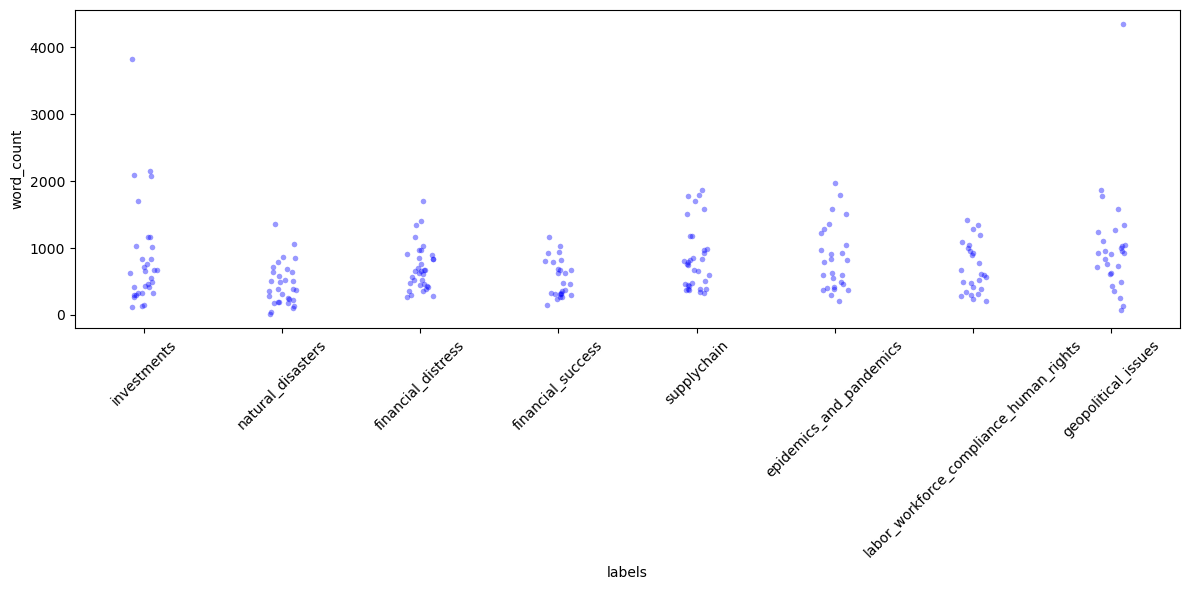

In [26]:
plt.figure(figsize=(12, 6))

sns.stripplot(
    x='labels', y='word_count', data=train_df_exp,
    jitter=True, alpha=0.4, color='blue', size=4
)
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Takeaway

Means appear about the same, Variances may differe but low sample count. Run a test to confirm

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('word_count ~ C(labels)', data=train_df_exp).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq     df         F    PR(>F)
C(labels)  6.588749e+06    7.0  3.510792  0.001341
Residual   6.139532e+07  229.0       NaN       NaN


### Takeaway

Word counts do vary signifficantly between articles

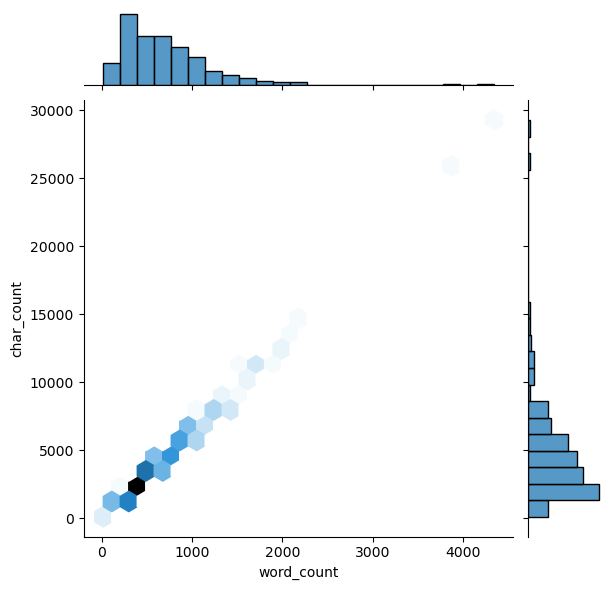

,char_count,word_count
char_count,1.000000,0.996886
word_count,0.996886,1.000000


In [28]:
sns.jointplot(data=train_df, x="word_count", y="char_count", kind="hex")
plt.show()

train_df_exp[["char_count", "word_count"]].corr()

### Takeaway

Word count and char count represent the same signal

# Keyword Exploration

## TFIDF

In [29]:
vect = TfidfVectorizer(
    max_df = .75 # Remove words in more than 75% of the documents
    ,min_df = 2 # Only keep words in at least 5 documents
    ,ngram_range= (1,2) # unigrams and bigrams
    ,stop_words = "english"
)

X_tfidf = vect.fit_transform(train_df_exp['text'])
feature_names = np.array(vect.get_feature_names_out())

print(X_tfidf.shape)

(237, 23254)


In [30]:
tfidf_sums = np.array(X_tfidf.sum(axis=0)).ravel()
top20 = feature_names[np.argsort(tfidf_sums)[-20:]][::-1]

print(top20)

['said' 'company' 'supply' 'year' 'billion' 'chain' 'china' 'supply chain'
 'million' 'new' 'amazon' 'companies' 'people' 'financial' 'quarter'
 'growth' 'business' 'according' 'pandemic' 'ai']


In [31]:
n = 15 # Number of top terms to show per label
labels = train_df_exp['labels'].unique()
rows = []

for lbl in labels:
    msk = train_df_exp['labels'] == lbl
    
    top_scores = X_tfidf[msk.values].sum(axis=0).A1
    top_terms = feature_names[np.argsort(top_scores)[-n:]][::-1]

    max_scores = X_tfidf[msk.values].max(axis=0).toarray().ravel()
    top_terms_max = feature_names[np.argsort(max_scores)[-n:]][::-1]

    rows.append({"label": lbl, "top_terms_sum": top_terms.tolist(), "top_terms_max": top_terms_max.tolist()})


# Dataframe for Display
df_top_terms = pd.DataFrame(rows)
pd.set_option('display.max_colwidth', None)
display(df_top_terms)

,label,top_terms_sum,top_terms_max
0,investments,"[billion, company, ai, said, year, acquisition, revenue, companies, crypto, capital, business, bitcoin, china, investors, ipo]","[bitcoin, amazon, percent, instacart, goldman, crypto, utility, trailer, acquisition, ai, billion, zinsner, intel, croatia, blink]"
1,natural_disasters,"[earthquake, heat, storm, said, damage, weather, people, magnitude, power, airport, miles, volcano, area, magnitude earthquake, county]","[heat, airlines, alaska, turkey, degrees, airport, snow, canada, türkiye, eu, lava, power, flights, rainfall, park]"
2,financial_distress,"[company, crypto, plan, said, bitcoin, sales, yellow, million, ubs, ftx, bankruptcy, stock, quarter, amazon, billion]","[amazon, bitcoin, crypto, intel, yellow, ubs, apple, citi, trust, morgan, ftx, boeing, prime, old dominion, dominion]"
3,financial_success,"[growth, quarter, year, billion, company, strong, million, demand, sales, rose, said, increase, revenue, dell, ai]","[laboratories, dell, cargo, xbox, growth, instacart, county, triangle, carbon, score, crh, siemens, second quarter, rank, roe]"
4,supplychain,"[supply, chain, supply chain, ford, apple, said, production, logistics, company, freight, industry, strike, siemens, global, firms]","[ford, sudan, apple, rail, yellow, gscpi, siemens, amazon, jarrett, boeing, procurement, jerry, ben jerry, ben, design]"
5,epidemics_and_pandemics,"[said, pandemic, freight, virus, covid, egg, year, supply, dogs, health, covid 19, 19, mexico, people, prices]","[dogs, mexico, virus, egg, ebola, yellow, ford, county, ftr, transport, settlement, society, snabe, firms, railways]"
6,labor_workforce_compliance_human_rights,"[workers, labor, said, company, amazon, twitter, compliance, employees, drivers, pay, contract, union, train, strike, overtime]","[detroit, martinez, arbitration, amazon, discover, yellow, mcdonald, auto, microsoft, compliance, forced labor, werner, layoffs, contract, train]"
7,geopolitical_issues,"[china, attacks, chinese, ukraine, countries, world, russia, supply, gold, sudan, country, beijing, said, huawei, production]","[attacks, indonesia, gold, gscpi, apple, china, venice, huawei, shanghai, croatia, chinese, minerals, ingredient, sudan, gas]"


### Takeaway
- Top terms pass the eyeball test. 
- Some concern with many specific countries being called out in geopolitical issues. This may represent todays issues well but may have issues abstractin to other regions or future challenges
- It may be challenging to differentiate between investments and financial succes. these have many of the same top words

## Word by Word predictive power

In [32]:
top_terms = df_top_terms.explode('top_terms_sum')['top_terms_sum'].unique()
print(top_terms)

['billion' 'company' 'ai' 'said' 'year' 'acquisition' 'revenue'
 'companies' 'crypto' 'capital' 'business' 'bitcoin' 'china' 'investors'
 'ipo' 'earthquake' 'heat' 'storm' 'damage' 'weather' 'people' 'magnitude'
 'power' 'airport' 'miles' 'volcano' 'area' 'magnitude earthquake'
 'county' 'plan' 'sales' 'yellow' 'million' 'ubs' 'ftx' 'bankruptcy'
 'stock' 'quarter' 'amazon' 'growth' 'strong' 'demand' 'rose' 'increase'
 'dell' 'supply' 'chain' 'supply chain' 'ford' 'apple' 'production'
 'logistics' 'freight' 'industry' 'strike' 'siemens' 'global' 'firms'
 'pandemic' 'virus' 'covid' 'egg' 'dogs' 'health' 'covid 19' '19' 'mexico'
 'prices' 'workers' 'labor' 'twitter' 'compliance' 'employees' 'drivers'
 'pay' 'contract' 'union' 'train' 'overtime' 'attacks' 'chinese' 'ukraine'
 'countries' 'world' 'russia' 'gold' 'sudan' 'country' 'beijing' 'huawei']


In [33]:


results = []
for term in top_terms:

    i = np.where(feature_names == term)[0][0]
    vals = X_tfidf[:, i].toarray().ravel()
    df_anova = pd.DataFrame({
        "tfidf": vals,
        "label": train_df_exp["labels"].values
    })
    
    #ols model and test for signifficance
    model = smf.ols("tfidf ~ C(label)", data=df_anova).fit()
    aov = sm.stats.anova_lm(model, typ=2)
    

    # Extract and structure data
    f_val = aov.loc["C(label)", "F"]
    p_val = aov.loc["C(label)", "PR(>F)"]
    results.append({
        "term": term,
        "F": f_val,
        "p_raw": p_val
    })

# bonferroni adjustment since we are doing many tests
anova_df = pd.DataFrame(results).sort_values("p_raw")
pvals = anova_df["p_raw"].values
reject, p_bonf, _, _ = multipletests(pvals, alpha=0.05, method="bonferroni")

anova_df["p_bonferroni"] = p_bonf
anova_df["significant"] = reject

anova_df = anova_df.sort_values("p_bonferroni")
display(anova_df[anova_df["significant"] == True])

,term,F,p_raw,p_bonferroni,significant
45,supply,17.736141,9.631364e-19,8.668227e-17,True
46,chain,13.846545,6.259857e-15,5.633871e-13,True
47,supply chain,13.242745,2.584771e-14,2.326294e-12,True
68,workers,11.556752,1.469468e-12,1.322521e-10,True
60,covid,9.973973,7.268194e-11,6.541375e-09,True
19,weather,9.821034,1.065387e-10,9.588484e-09,True
74,pay,9.769543,1.212035e-10,1.090832e-08,True
24,miles,9.241766,4.573341e-10,4.116007e-08,True
64,covid 19,8.552309,2.634510e-09,2.371059e-07,True
12,china,8.403021,3.858170e-09,3.472353e-07,True


### Takeaway 
There is signal in tfidf values directly for classificaiton even after bonferroni adjustments. This provides confidence in our ability to classify documents

# Dimensionality Reduction

## Truncated SVD

dimensions before reduction (237, 23254)
dimensions before reduction (237, 237)


Text(0, 0.5, 'Explained Variance')

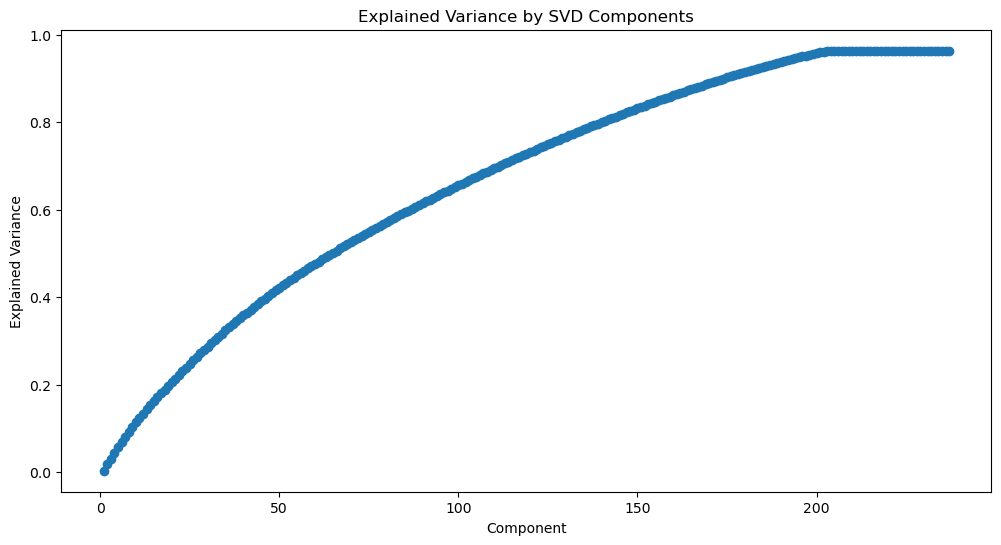

In [41]:
svd = TruncatedSVD(n_components= 500, random_state=42)

print("dimensions before reduction", X_tfidf.shape)
X_reduced = svd.fit_transform(X_tfidf)
print("dimensions before reduction", X_reduced.shape)


explained_variance = svd.explained_variance_

explained_variance_cumsum = np.cumsum(explained_variance)


plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance_cumsum, marker='o')
plt.title("Explained Variance by SVD Components")
plt.xlabel("Component")

plt.ylabel("Explained Variance")

In [42]:
terms = vect.get_feature_names_out()
for comp_idx, comp in enumerate(svd.components_[:20]):        # e.g. first 5
    top_idx   = comp.argsort()[::-1][:10]                   # highest weights
    top_terms = [terms[j] for j in top_idx]
    print(f"Component {comp_idx}: {top_terms}")


Component 0: ['said', 'company', 'supply', 'year', 'chain', 'billion', 'supply chain', 'china', 'amazon', 'million']
Component 1: ['supply', 'chain', 'supply chain', 'yellow', 'ford', 'freight', 'logistics', 'firms', 'gscpi', 'pandemic']
Component 2: ['yellow', 'crypto', 'amazon', 'workers', 'bitcoin', 'teamsters', 'freight', 'bankruptcy', 'cryptocurrency', 'twitter']
Component 3: ['uk', 'debt', 'fitch', 'inflation', 'crypto', 'bitcoin', 'government', 'downgrade', 'finances', 'public finances']
Component 4: ['prices', 'crypto', 'bird', 'sugar', 'bloomberg', 'poultry', 'flu', 'food', 'chicken', 'bird flu']
Component 5: ['yellow', 'uk', 'debt', 'freight', 'fitch', 'teamsters', 'billion', 'downgrade', 'finances', 'government']
Component 6: ['crypto', 'bitcoin', 'yellow', 'cryptocurrency', 'ftx', 'uk', 'ford', 'inflation', 'debt', 'company']
Component 7: ['apple', 'china', 'yellow', 'beijing', 'chinese', 'freight', 'production', 'apple stock', 'geopolitical', 'ai']
Component 8: ['ford', 'a

### Takeaway
- Groupings arguably make sense, but positive and negative weights make it hard to interpret. Going to swap to NMF.

# NMF For more interpretable features

In [36]:
n_topics = 15

nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(X_tfidf)
H = nmf.components_

for topic_idx, topic in enumerate(H):
    top_terms = [terms[i] for i in topic.argsort()[::-1][:10]]
    print(f"Topic #{topic_idx}: {top_terms}")

Topic #0: ['quarter', 'billion', 'revenue', 'company', 'million', 'year', 'sales', 'growth', 'earnings', 'ai']
Topic #1: ['supply', 'supply chain', 'chain', 'logistics', 'said', 'freight', 'suppliers', 'business', 'industry', 'visibility']
Topic #2: ['county', 'said', 'earthquake', 'storm', 'people', 'heat', 'weather', 'magnitude', 'damage', 'area']
Topic #3: ['uk', 'debt', 'fitch', 'downgrade', 'finances', 'government', 'credit', 'uk government', 'public finances', 'inflation']
Topic #4: ['prices', 'bird', 'bloomberg', 'sugar', 'poultry', 'flu', 'food', 'bird flu', 'chicken', 'virus']
Topic #5: ['yellow', 'freight', 'teamsters', 'pension', 'bankruptcy', 'trucking', 'union', 'company', 'dominion', 'old dominion']
Topic #6: ['crypto', 'bitcoin', 'cryptocurrency', 'ftx', 'cryptocurrencies', 'digital', 'exchanges', '2022', 'crash', 'says']
Topic #7: ['apple', 'production', 'china', 'company', 'apple stock', 'stock', 'beijing', 'risks', 'geopolitical', 'mitigate']
Topic #8: ['ford', 'lawle

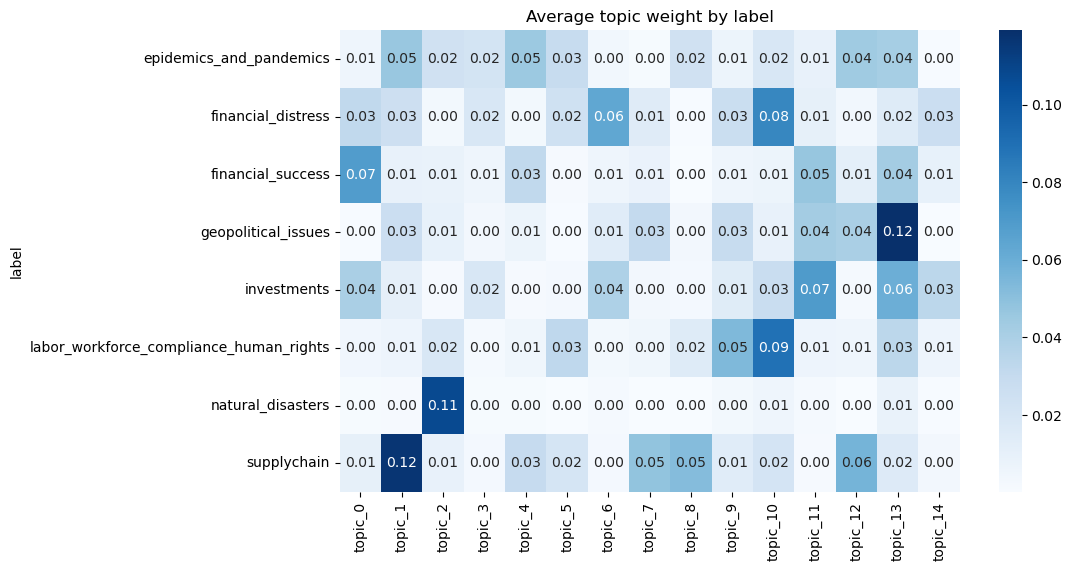

In [37]:
topic_cols = ["topic_" + str(i) for i in range(n_topics)]
df = pd.DataFrame(W, columns = topic_cols)

df["label"] = train_df_exp["labels"].values
df['short_label'] = df['label'].apply(
    lambda x: x if len(x) <= 15 else x[:15] + '…'
)

means = df.groupby('label')[topic_cols].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(means, cmap="Blues", annot=True, fmt=".2f")
plt.title("Average topic weight by label")
plt.show()

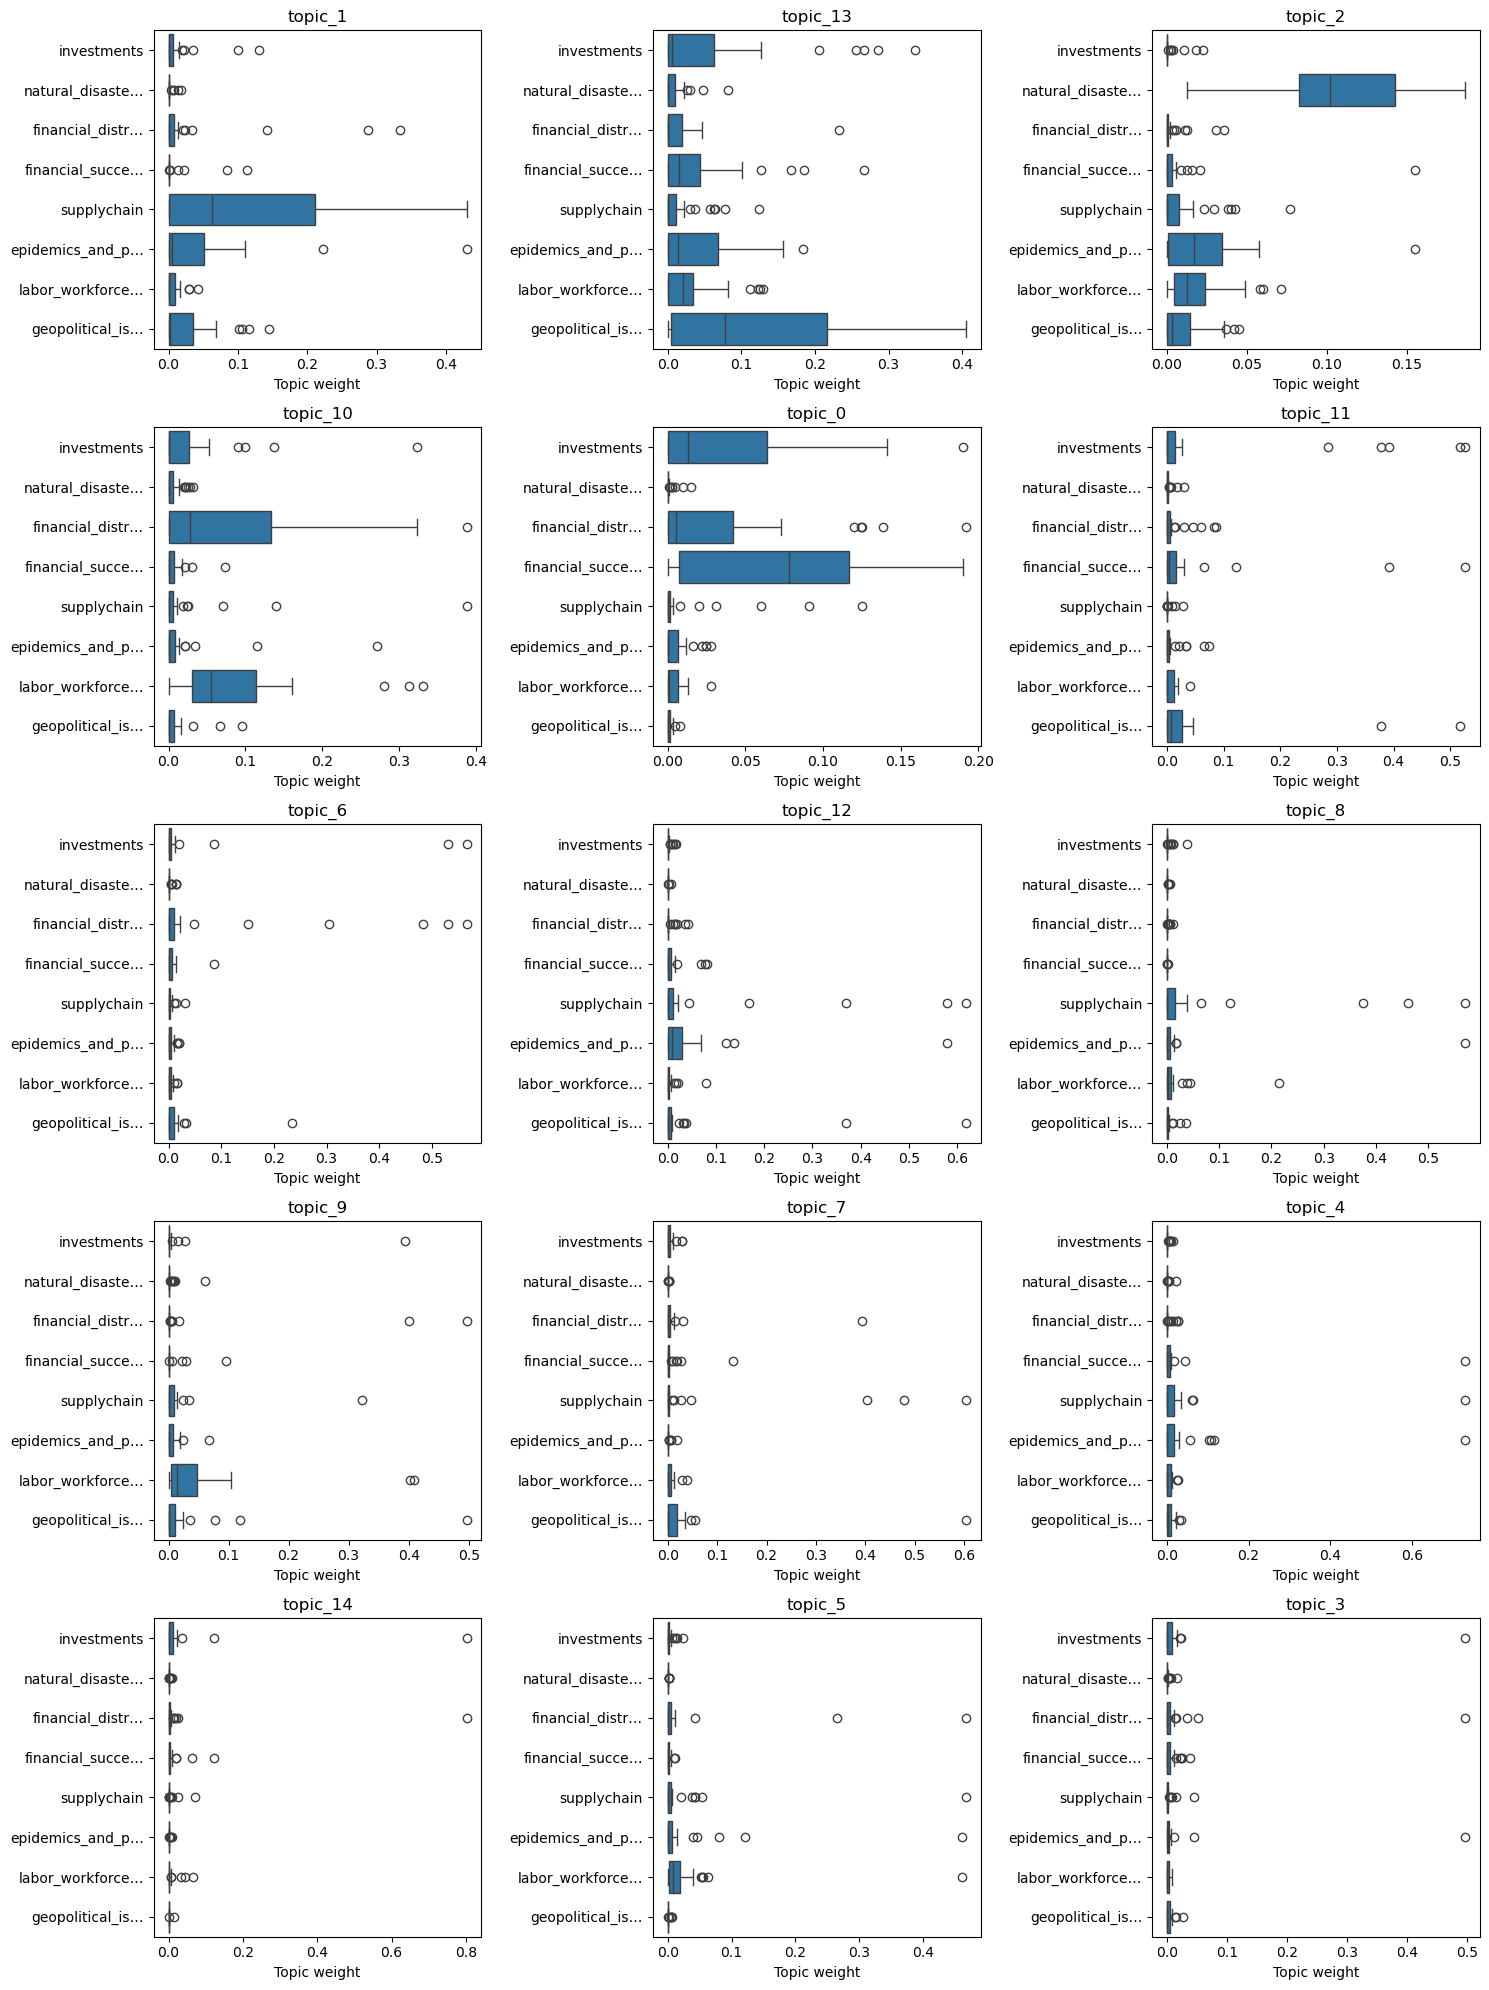

In [38]:

import math
ranges     = means.max(axis=0) - means.min(axis=0)
top_topics = ranges.sort_values(ascending=False).head(15).index.tolist()

n = len(top_topics)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(5*ncols, 4*nrows),
                         sharex=False, sharey=False)
axes = axes.flatten()

for ax, topic in zip(axes, top_topics):
    sns.boxplot(x=topic, y='short_label', data=df, ax=ax, orient='h')
    ax.set_title(f"{topic}")
    ax.set_xlabel("Topic weight")
    ax.set_ylabel("")


plt.tight_layout()
plt.show()


# PCA for Plotting

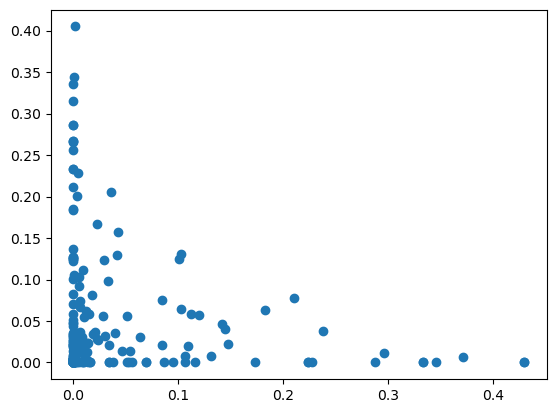

In [40]:
from sklearn.decomposition import PCA

X_tfidf